# Lab 5. Work with the OpenCV library

## Task 1
Determine the number of options by the formula, where X is the first capital letter of your name in Latin transcription.

In [1]:
x = "Inessa Repeshko"
variant_number = ord(x[0].upper()) % 5 + 1
print(f'Variant # {variant_number}')

Variant # 4


## Task 2
Load data from the file `lab5.xlsx` into the dataframe.

In [2]:
import pandas as pd

# Load data from the Excel file and display dataframe
file_path = 'lab5.xlsx'
df = pd.read_excel(file_path, index_col='N')
df

,file name,image size,glasses color,line width
N,,,,
1,emma-watson2.jpg,300x300,red,2
2,emma-watson.jpg,400x400,blue,3
3,draco.jpg,700x700,cian,4
4,longbottom.jpg,600x600,magenta,5
5,ron_wesley.jpg,500x500,yellow,6


In [3]:
# Fix a typo in the colour name in the table
df['glasses color'] = df['glasses color'].replace({'cian': 'cyan'})
df

,file name,image size,glasses color,line width
N,,,,
1,emma-watson2.jpg,300x300,red,2
2,emma-watson.jpg,400x400,blue,3
3,draco.jpg,700x700,cyan,4
4,longbottom.jpg,600x600,magenta,5
5,ron_wesley.jpg,500x500,yellow,6


## Task 3
Get data to your version programmatically from the dataframe using indexing tools.

In [4]:
# Extract data for the specified variant
var_4_data = df.loc[variant_number]
var_4_data

file name        longbottom.jpg
image size              600x600
glasses color           magenta
line width                    5
Name: 4, dtype: object

## Task 4
Create a function that accepts data from the dataframe as arguments and returns a reduced image with added ‘round glasses’ and saves the resulting image to a file.

### Remarks
1. When reducing the image, place the face in the centre of the picture.
2. To detect faces and eyes, use `Haar Cascade` from the `OpenCV` library.
3. Use `PIL` and/or `OpenCV` libraries for drawing (optional).
4. As a result, upload the Jupyter notebook to Teams Assignments.

### Fulfilment of the assignment requirements

| Done  | N  | Completed Task                                                                                       | Points |
|------ |----|------------------------------------------------------------------------------------------------------|--------|
| ✅    | 1  | Loading content from .xlsx file into DataFrame                                                       | 5      |
| ✅    | 2  | Programmatic access to DataFrame for obtaining data for the personal task                            | 10     |
| ✅    | 3  | Face detection in the image                                                                          | 10     |
| ✅    | 4  | Eye detection in the image                                                                           | 10     |
| ✅    | 5  | Setting parameters for accurate eye detection                                                        | 5      |
| ✅    | 6  | Adding "glasses frames"                                                                               | 5      |
| ✅    | 7  | Adding "glasses nose bridge"                                                                         | 10     |
| ✅    | 8  | Adding "glasses rim"                                                                                 | 10     |
| ✅    | 9  | Centering the face in the resized image                                                              | 5      |
| ✅    | 10 | Image resizing                                                                                       | 5      |
| ✅    | 11 | Setting the correct color for the "glasses"                                                          | 5      |
| ✅    | 12 | Setting the correct line thickness                                                                   | 5      |
| ✅    | 13 | Adding the ability to change "glasses" parameters (color, thickness) when values change in DataFrame | 10     |
| ✅    | 14 | Presence of function tests on other images (of your choice)                                          | 5      |

### Realisation of Task 4

In [5]:
%pip install opencv-python pillow termcolor

Note: you may need to restart the kernel to use updated packages.


In [6]:
from matplotlib import colors
import os
import cv2
import numpy as np
from PIL import Image
from termcolor import colored

Load Haar Cascade files from the OpenCV library to detect faces and eyes in the image.

`cv2.data.haarcascades` is the path to the built-in folder where OpenCV stores Haar cascade files by default.

In [7]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

if face_cascade.empty() or eye_cascade.empty():
    print(colored("Error! Failed to load Haar Cascade files files from the OpenCV library.", "red", attrs=["bold"]))
else: 
    print(colored("Successfully uploaded Haar Cascade files files from the OpenCV library.", "green", attrs=["bold"]))

Successfully uploaded Haar Cascade files files from the OpenCV library.


In [8]:
def load_image(image_file_name):
    """
    Uploads an image with the specified name.
    """
    image_path = f"./Images/{image_file_name}"

    return cv2.imread(image_path)

In [9]:
def convert_color_to_bgr(glasses_color):
    """
    Converts the name of the glasses color to BGR format.
    """
    try:
        # Convert the text name of a color (‘red’, ‘blue’, etс.) 
        # to its numeric RGB representation (with normalisation in the range from 0 to 1)
        rgb_color = colors.to_rgb(glasses_color)
        
        # Convert to BGR (0 to 255)
        bgr_color = tuple(map(lambda c: int(c * 255), reversed(rgb_color)))
        
        return bgr_color
    except ValueError:
        return None

In [10]:
def detect_face(image):
    """
    Detects the coordinates and size of the face in the specified image.
    """
    # Convert image to black and white format for `face_cascade.detectMultiScale()` function 
    # that searches for gradients (changes in pixel intensity) in a black and white image to detect faces.
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # The `face_cascade.detectMultiScale()` function analyzes the image 
    # and returns the coordinates of the rectangles that bound the detected faces.
    # `minNeighbors` - specify the minimum number of neighboring windows that must overlap to recognize an object as a face;
    # `minSize` - specify the minimum size of the face in pixels that can be detected.
    faces = face_cascade.detectMultiScale(gray_image, minNeighbors=5, minSize=(100, 100))
    
    return faces[0] if len(faces) > 0 else None

In [11]:
def crop_and_resize_face(image, face_coords, target_size):
    """
    Crops the input image to a region containing the face and resizes it to the target dimensions.
    """
    # Get the coordinates and size of a rectangle with a face
    x, y, w, h = face_coords
    
    # Get the target width and height of image
    target_width, target_height = target_size

    # Calculate how much to expand the width and height 
    # of the face rectangle to maintain the proportions of the target size
    add_w = (target_width - w) // 2
    add_h = (target_height - h) // 2

    # Calculate the coordinates of:
    # - the upper left corner
    crop_x1 = x - add_w
    crop_y1 = y - add_h
    # - the lower right corner
    crop_x2 = min(x + w + add_w, image.shape[1])
    crop_y2 = min(y + h + add_h, image.shape[0])

    # Adjust the crop rectangle if the upper-left corner goes out of bounds.
    # Shift the lower-right corner to compensate and ensure the rectangle fits within the image.
    crop_y2, crop_y1 = (crop_y2 - crop_y1, 0) if crop_y1 < 0 else (crop_y2, crop_y1)
    crop_x2, crop_x1 = (crop_x2 - crop_x1, 0) if crop_x1 < 0 else (crop_x2, crop_x1)

    # Crop the area of the image that corresponds to the calculated coordinates
    cropped_image = image[crop_y1:crop_y2, crop_x1:crop_x2]
    
    # Resize image only if dimensions (width and height) of the cropped image do not match the target size
    if cropped_image.shape[:2] != target_size:
        cropped_image = cv2.resize(cropped_image, target_size, interpolation=cv2.INTER_LANCZOS4)

    return cropped_image

In [12]:
def detect_eyes(cropped_face):
    """
    Detects the coordinates and size of the eyes in the specified face image.
    """
    # Convert cropped face image to black and white format for `eye_cascade.detectMultiScale()` function 
    # that searches for gradients (changes in pixel intensity) in a black and white image to detect eyes.
    gray_face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2GRAY)

    # The `eye_cascade.detectMultiScale()` function analyzes the image 
    # and returns the coordinates of the rectangles that bound the detected eyes.
    # `minNeighbors` - specify the minimum number of neighboring windows that must overlap to recognize an object as a eye;
    # `minSize` - specify the minimum size of the eye in pixels that can be detected.
    eyes = eye_cascade.detectMultiScale(gray_face, minNeighbors=8, minSize=(30, 30))

    # Return None if fewer than two eyes are detected
    if len(eyes) < 2:
        return None

    # Sort detected eyes by their x-coordinate (horizontal position)
    eyes_sorted = sorted(eyes, key=lambda ex: ex[0])
    
    return eyes_sorted

In [13]:
def draw_glasses_on_eyes(face_image, eye_coords, glasses_color, line_width):
    """
    Draw glasses on the detected eyes, taking into account the scaling.
    """
    # Get the coordinates and sizes of rectangles with eyes
    (ex1, ey1, ew1, eh1) = eye_coords[0]
    (ex2, ey2, ew2, eh2) = eye_coords[1]

    # Calculation of eye centers: the center of the eye is calculated 
    # as the middle of the rectangle coordinates
    eye1_center = (int(ex1 + ew1 // 2), int(ey1 + eh1 // 2))
    eye2_center = (int(ex2 + ew2 // 2), int(ey2 + eh2 // 2))

    # Calculate the radius for circles (glasses lenses):
    radius = int(max(ew1, eh1) // 2)

    # Draw circles for glasses lenses for each eye
    cv2.circle(face_image, eye1_center, radius, glasses_color, line_width)
    cv2.circle(face_image, eye2_center, radius, glasses_color, line_width)

    # Draw lines to connect the glasses:
    # - nose bridge of the glasses : 
    # а line is drawn between the rightmost edge of the first lens and the leftmost edge of the second lens
    cv2.line(face_image,                                              # Image to draw the line on (NumPy array)
             (eye1_center[0] + radius, eye1_center[1]),               # Coordinates of the starting point of the line as (x, y)
             (eye2_center[0] - radius, eye2_center[1]),               # Coordinates of the end point of the line as (x, y)
             glasses_color,                                           # Line color in BGR format
             line_width)                                              # Line thickness in pixels

    # - eyeglasses frame on the left:
    # a line starts from the left edge of the first (left) lens to the specified length
    cv2.line(face_image,                                              # Image to draw the line on (NumPy array)
             (eye1_center[0] - radius, eye1_center[1]),               # Coordinates of the starting point of the line as (x, y)
             (eye1_center[0] - radius - 30, eye1_center[1] - 10),     # Coordinates of the end point of the line as (x, y)
             glasses_color,                                           # Line color in BGR format
             line_width)                                              # Line thickness in pixels

    # - eyeglasses frame on the right:
    # a line starts from the right edge of the second (right) lens to the specified length
    cv2.line(face_image,                                              # Image to draw the line on (NumPy array)
             (eye2_center[0] + radius, eye2_center[1]),               # Coordinates of the starting point of the line as (x, y)
             (eye2_center[0] + radius + 30, eye2_center[1] - 10),     # Coordinates of the end point of the line as (x, y) 
             glasses_color,                                           # Line color in BGR format
             line_width)                                              # Line thickness in pixels

In [14]:
def save_image(image, filename):
    """
    Saves the created image in the specified directory.
    """
    # Get the file name and its format separately
    base_name, ext = os.path.splitext(filename)
    
    # Create an output file name
    output_filename = f"{base_name}_with_glasses{ext}"
    
    # Create an output folder if it does not already exist
    os.makedirs('output', exist_ok=True)

    # Specify the path to save the file
    output_path = os.path.join("output", output_filename)

    # Save the image in the specified format and path and display a message about saving the file
    cv2.imwrite(output_path, image)
    print(colored(f"The image with the drawn glasses is saved to: {output_path}", "green", attrs=["bold"]))

In [15]:
def process_image(data):
    # Get the initial data from the task variant requirement
    image_file_name = data['file name']
    glasses_color_name = data['glasses color']
    line_width = int(data['line width'])
    image_size = data['image size']
    target_width, target_height = map(int, image_size.split('x'))

    # Upload an image for processing
    image = load_image(image_file_name)

    # If an incorrect image file name is specified, display an error message and return None
    if image is None:
        print(colored("Error! Image file upload failed. Incorrect image file name is specified.", "red", attrs=["bold"]))
        return None

    # Get the color of glasses in BGR format
    glasses_color = convert_color_to_bgr(glasses_color_name)

    # If the color name is incorrect, output an error message and the original image
    if glasses_color is None:
        print(colored("Error! Failed to get the color of the glasses. Invalid glasses color name provided", "red", attrs=["bold"]))
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get the coordinates and size of the rectangle with the face in the image
    face_coords = detect_face(image)

    # If no face is found in the image, display an error message and the original image
    if face_coords is None:
        print(colored("Error! Could not find a face in the image.", "red", attrs=["bold"]))
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get a cropped rectangle with a face with resizing to a specified size
    cropped_and_resized_face = crop_and_resize_face(image, face_coords, (target_width, target_height))

    # Get the coordinates and size of the rectangles with the eyes in the image
    eye_coords = detect_eyes(cropped_and_resized_face)

    # If no pair of eyes is found in the image, display an error message and the cropped and resized face image
    if eye_coords is None:
        print(colored("Error! Not enough eyes were found to add glasses.", "red", attrs=["bold"]))
        return cv2.cvtColor(cropped_and_resized_face, cv2.COLOR_BGR2RGB)

    # Add glasses to a face based on eye coordinates
    draw_glasses_on_eyes(cropped_and_resized_face, eye_coords, glasses_color, line_width)

    # Save the modified image as a file
    save_image(cropped_and_resized_face, image_file_name)

    # Return an image with drawn glasses in RGB format
    return cv2.cvtColor(cropped_and_resized_face, cv2.COLOR_BGR2RGB)

### Below are the results of executing the code for all task variants.
#### 🔽 Results of code execution for the requirement of Variant # 4 🔽

The image with the drawn glasses is saved to: output/longbottom_with_glasses.jpg


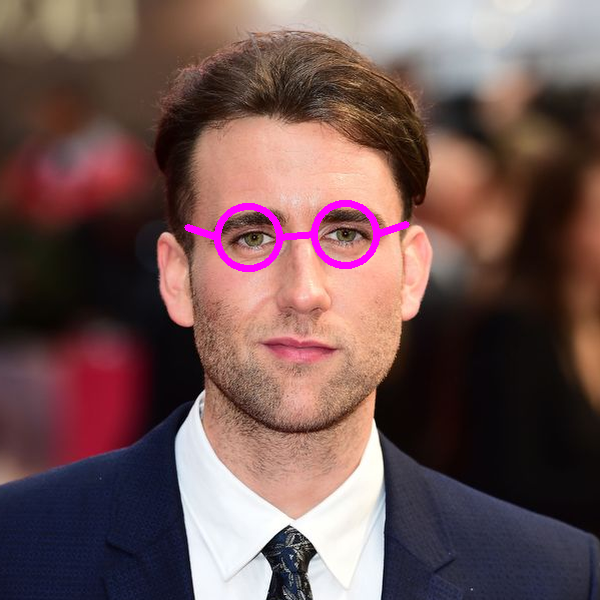

In [16]:
Image.fromarray(process_image(var_4_data))

#### 🔽 Results of code execution for the requirement of Variant # 1 🔽

In [17]:
var_1_data = df.loc[1]
var_1_data

file name        emma-watson2.jpg
image size                300x300
glasses color                 red
line width                      2
Name: 1, dtype: object

The image with the drawn glasses is saved to: output/emma-watson2_with_glasses.jpg


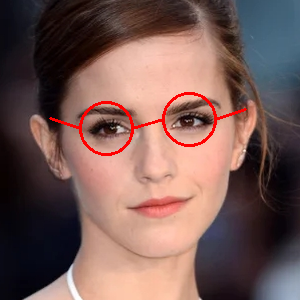

In [18]:
Image.fromarray(process_image(var_1_data))

#### 🔽 Results of code execution for the requirement of Variant # 2 🔽

In [19]:
var_2_data = df.loc[2]
var_2_data

file name        emma-watson.jpg
image size               400x400
glasses color               blue
line width                     3
Name: 2, dtype: object

The image with the drawn glasses is saved to: output/emma-watson_with_glasses.jpg


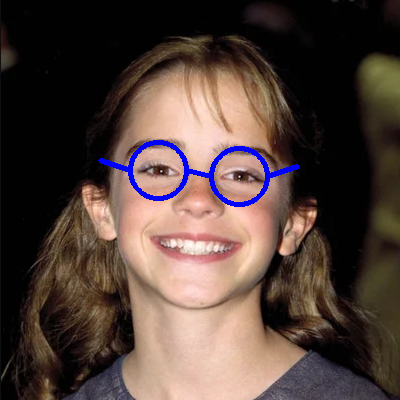

In [20]:
Image.fromarray(process_image(var_2_data))

#### 🔽 Results of code execution for the requirement of Variant # 3 🔽

In [21]:
var_3_data = df.loc[3]
var_3_data

file name        draco.jpg
image size         700x700
glasses color         cyan
line width               4
Name: 3, dtype: object

The image with the drawn glasses is saved to: output/draco_with_glasses.jpg


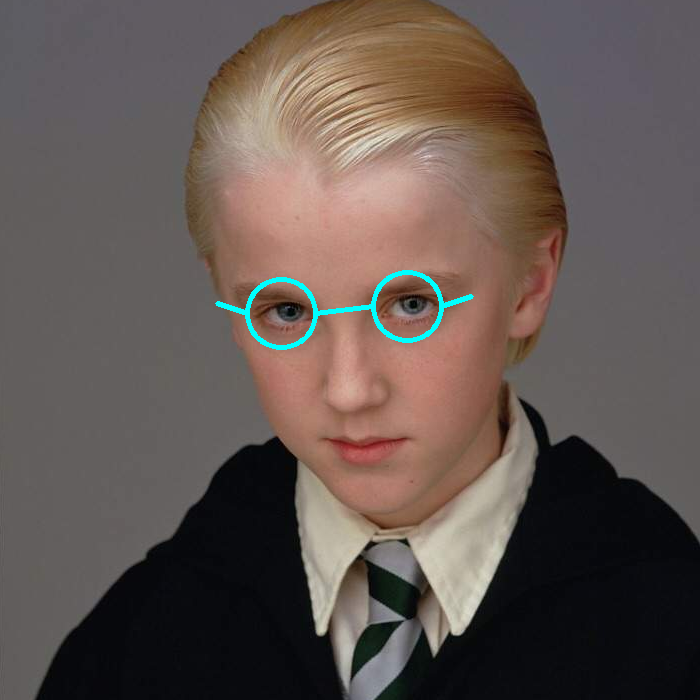

In [22]:
Image.fromarray(process_image(var_3_data))

#### 🔽 Results of code execution for the requirement of Variant # 5 🔽

In [23]:
var_5_data = df.loc[5]
var_5_data

file name        ron_wesley.jpg
image size              500x500
glasses color            yellow
line width                    6
Name: 5, dtype: object

The image with the drawn glasses is saved to: output/ron_wesley_with_glasses.jpg


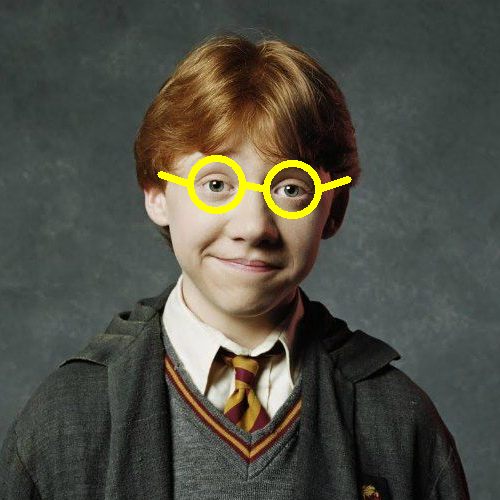

In [24]:
Image.fromarray(process_image(var_5_data))

#### 🔽 Results of code execution for CUSTOM COLOR 🔽

In [25]:
df.loc[len(df) + 1] = ['Daniel_Radcliffe.jpg', '400x600', 'mediumpurple', 10]
custom_color_data = df.loc[len(df)]
custom_color_data

file name        Daniel_Radcliffe.jpg
image size                    400x600
glasses color            mediumpurple
line width                         10
Name: 6, dtype: object

The image with the drawn glasses is saved to: output/Daniel_Radcliffe_with_glasses.jpg


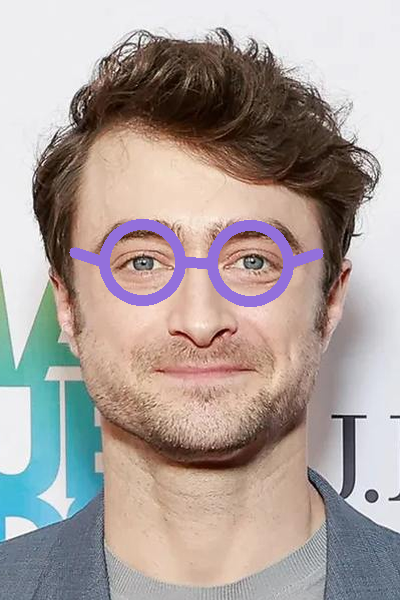

In [26]:
Image.fromarray(process_image(custom_color_data))